<a href="https://colab.research.google.com/github/geeorgebixleer/robot-trading-BTC-USD/blob/main/robot_trading_BTC_USD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Configurando el ambiente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import time

In [2]:
!python -V
!pip show Pandas
!pip show Numpy
!pip show Matplotlib

Python 3.10.12
Name: pandas
Version: 1.5.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, python-dateutil, pytz
Required-by: altair, arviz, bigframes, bokeh, bqplot, cmdstanpy, cufflinks, datascience, db-dtypes, dopamine-rl, fastai, geemap, geopandas, google-colab, gspread-dataframe, holoviews, ibis-framework, lida, mizani, mlxtend, pandas-datareader, pandas-gbq, panel, plotnine, prophet, pymc, seaborn, sklearn-pandas, statsmodels, vega-datasets, xarray, yfinance
Name: numpy
Version: 1.23.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: albumentations, altair, arvi

In [3]:
# variables globales
global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

#2. Obtención de Datos

##2.1. Histórico BTC-USD

In [4]:
def importar_base_bitcoin():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  df_bitcoin = yf.download("BTC-USD", period="1wk", interval = "5m")
  df_bitcoin = pd.DataFrame(df_bitcoin)
  return df_bitcoin
importar_base_bitcoin()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-10-28 18:50:00+00:00,34161.605469,34183.648438,34161.605469,34183.648438,34183.648438,0
2023-10-28 18:55:00+00:00,34188.203125,34194.425781,34183.187500,34183.187500,34183.187500,0
2023-10-28 19:00:00+00:00,34173.597656,34173.910156,34171.046875,34172.613281,34172.613281,0
2023-10-28 19:05:00+00:00,34170.187500,34172.992188,34143.566406,34143.566406,34143.566406,0
2023-10-28 19:10:00+00:00,34159.628906,34159.628906,34154.375000,34156.128906,34156.128906,0
...,...,...,...,...,...,...
2023-11-04 18:25:00+00:00,34763.710938,34771.000000,34762.667969,34771.000000,34771.000000,59392
2023-11-04 18:30:00+00:00,34768.800781,34768.800781,34755.550781,34759.777344,34759.777344,91136
2023-11-04 18:35:00+00:00,34760.789062,34761.210938,34760.003906,34760.121094,34760.121094,583680


##2.2. Precio actual-tendencia BTC-USD

In [6]:
def extraer_tendencias():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'}
  url = 'https://coinmarketcap.com/'
  respuesta = requests.get(url, headers = headers)
  s = BeautifulSoup(respuesta.content, features = 'lxml')
  respuesta = s.findAll('p', {'class':'sc-4984dd93-0 iqdbQL coin-item-symbol'})

  indice = 0
  for item in respuesta:
    if item.getText()=='BTC':
     break
    indice+=1

  respuesta = s.findAll('div', {'class': ['sc-a0353bbc-0 gDrtaY', 'sc-0a353bbc-0 gDrtaY fall', 'sc-a0353bbc-0 gDrtaY rise' ]})
  precio_actual = float(respuesta[indice].getText().replace('$', '').replace(',',''))

  lista = []
  respuesta = s.findAll('span', {'class': ['sc-d55c02b-0 iwhBxy', 'sc-55c02b-0 gUnzUB']})
  for item in respuesta[::3]:
    lista.append(item)

  tendencia = ''
  if lista[indice].find('span')['class'][0] == 'icon-Caret-down':
    tendencia = 'baja'
  else:
    tendencia = 'alta'
extraer_tendencias()

#3.Limpieza de Datos

In [7]:
def limpieza_datos():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  df_bitcoin_limpio = pd.DataFrame(df_bitcoin)
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)
  volume0 = df_bitcoin_limpio['Volume'] > 0
  df_bitcoin_limpio = df_bitcoin_limpio[volume0]
limpieza_datos()

##3.4. Outliers ['Close']

<Axes: >

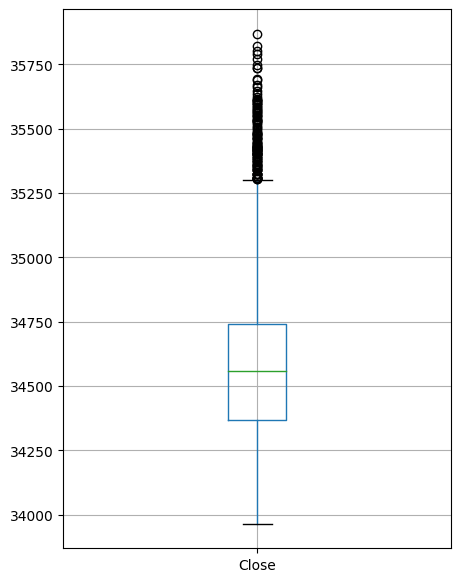

In [8]:
df_bitcoin_limpio.boxplot(['Close'], figsize = (5,7))

In [9]:
close = df_bitcoin_limpio['Close']
Q1 = close.quantile(.25)
Q3 = close.quantile(.75)
IIQ = Q3-Q1
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ
outliers_close = ((close >= limite_inferior) & (close <= limite_superior))
df_bitcoin_limpio = df_bitcoin_limpio[outliers_close]
media_bitcoin = df_bitcoin['Close'].mean()

<Axes: >

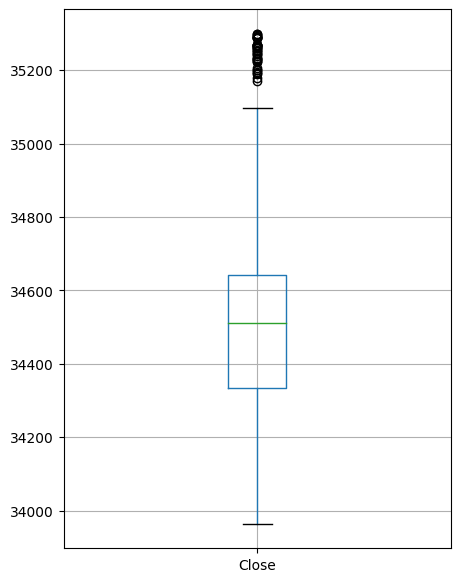

In [10]:
df_bitcoin_limpio.boxplot(['Close'], figsize = (5,7))

#4. Tomar Decisiones

In [11]:
def tomar_decisiones():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  if precio_actual >= media_bitcoin and tendencia == 'baja':
    algoritmo_decision = 'Vender'
  elif precio_actual < media_bitcoin and tendencia == 'alta':
    algoritmo_decision = ' Comprar'
  else:
    algoritmo_decision = 'Espera'
  return algoritmo_decision
tomar_decisiones()

'Espera'

#5. Visualización

In [12]:
def visualizacion():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  df_bitcoin['Promedio'] = media_bitcoin
  fig = plt.figure(figsize=(16,5))
  eje = fig.add_axes([0,0,1,1])
  eje.grid(True)

  eje.plot(df_bitcoin.index, df_bitcoin['Close'], color = 'g')
  eje.plot(df_bitcoin.index, df_bitcoin['Promedio'], color='r', linestyle='--')

  eje.set_title('Tendencia en tiempo real BTC-USD', fontsize=25, pad=20)
  eje.set_xlabel('Fecha', fontsize=20)
  eje.set_ylabel('BTC-USD', fontsize=20)

  eje.annotate('{}'.format(algoritmo_decision), xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), fontsize=15, color='r')

  print('Precio actual BTC-USD: {} \nPrecio promedio BTC-USD: {} \nTendencia BTC-USD: {}'.format(precio_actual, media_bitcoin.round(3), tendencia))
  plt.show()

#6. Automatización

[*********************100%%**********************]  1 of 1 completed
Precio actual BTC-USD: 34770.27 
Precio promedio BTC-USD: 34591.773 
Tendencia BTC-USD: alta


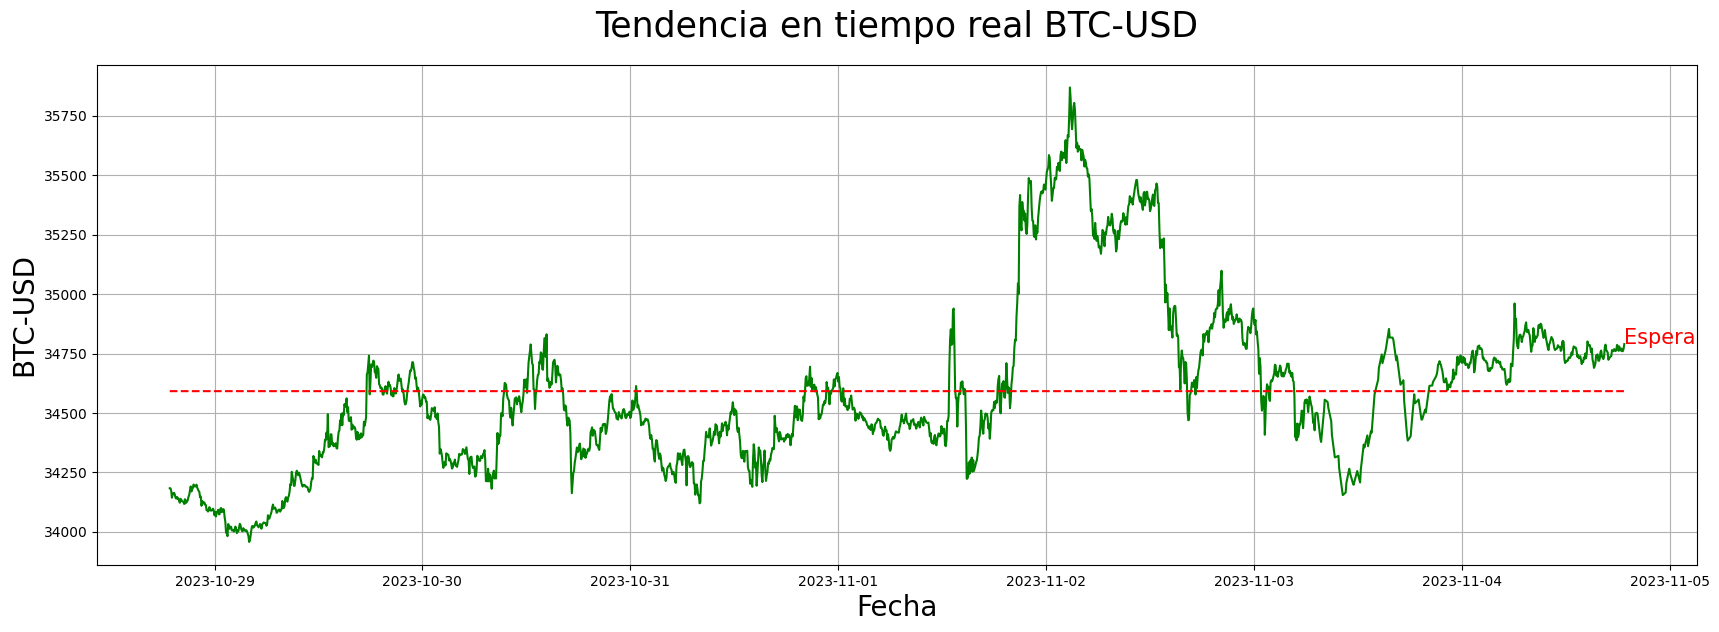

KeyboardInterrupt: ignored

In [13]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)